In [89]:
import pandas as pd
import re 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

train = pd.read_csv('/content/sample_data/train_E6oV3lV.csv')
test = pd.read_csv('/content/sample_data/test_tweets_anuFYb8.csv')



print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [90]:
print(train.head())
print('\n')
print(test.head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...


In [91]:
#data cleaning
combi = train.append(test,ignore_index= True)
def remove_pattern(input_txt,pattern):
  r = re.findall(pattern,input_txt)
  for i in r:
    input_txt = re.sub(i, '',input_txt)

  return input_txt
#removing twitter handle
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'],"@[\w]*")


<ipython-input-91-78a50c69fe93>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combi = train.append(test,ignore_index= True)


In [92]:
#remove special charters,numbers,panctuvations

combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")


<ipython-input-92-76f623f9f0f7>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")


In [93]:
#remove short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi['tidy_tweet'].head()

0    when father dysfunctional selfish drags kids i...
1    thanks #lyft credit cause they offer wheelchai...
2                                  bihday your majesty
3                           #model love take with time
4                       factsguide society #motivation
Name: tidy_tweet, dtype: object

In [94]:
#tokenization

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [95]:
#stemming 
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [96]:
#stich 
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

<function matplotlib.pyplot.show(close=None, block=None)>

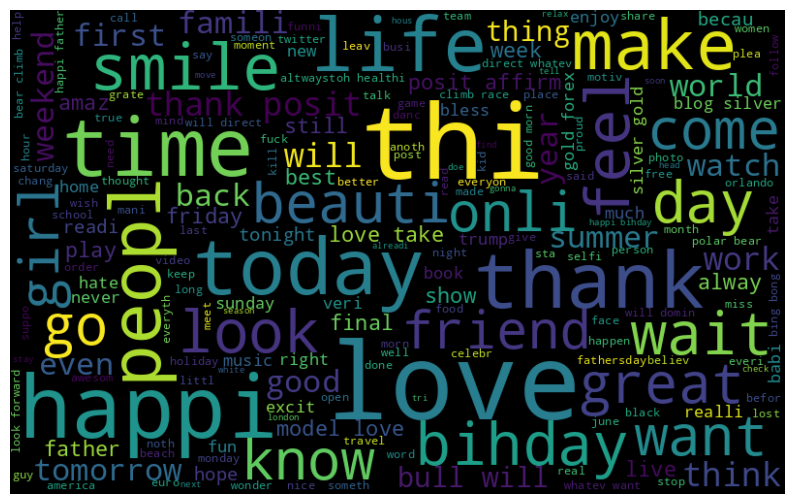

In [97]:
from pandas.io.pytables import WORMTable
#story generation and visulation from tweets
#comman words  used inn tweets

all_words = ' '.join([text for text in combi['tidy_tweet']]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width = 800,height = 500, random_state= 21,max_font_size=110).generate(all_words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

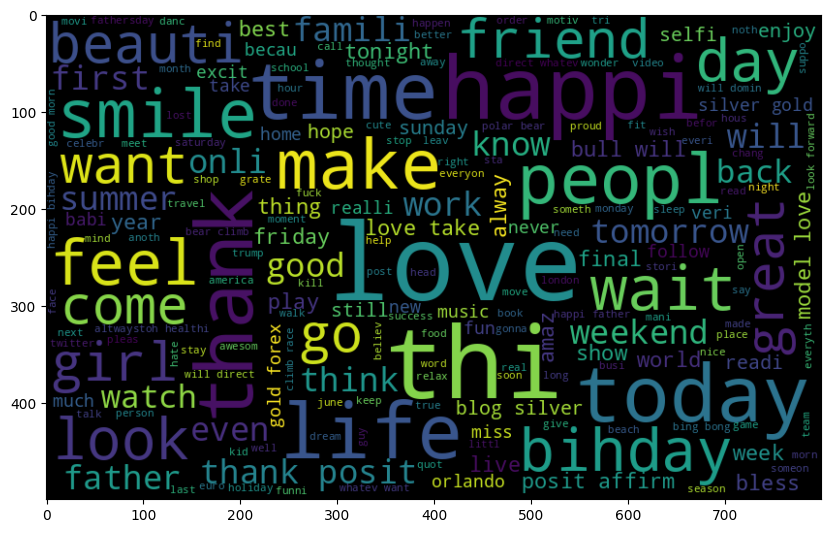

In [98]:
#normal words
normal_words =' '.join([text for text  in combi['tidy_tweet'][combi['label'] == 0]])


wordcloud = WordCloud(width = 800, height = 500, random_state = 10,max_font_size = 110).generate(normal_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('on')
plt.show

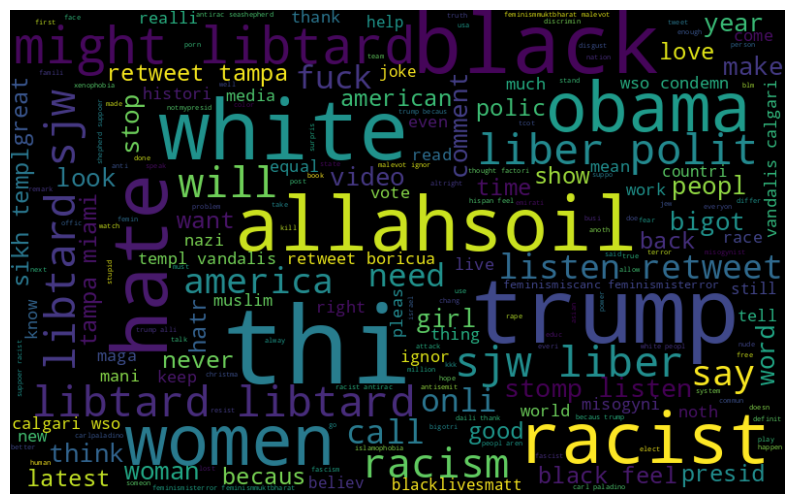

In [99]:
#racist/sexist tweets
negative_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 


wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size= 110 ).generate(negative_words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [100]:
#fuction to collect hashtags
def hashtag_extract(x):
  hashtags = []
  #loop  over the words in the tweet
  for i in x:
    ht = re.findall(r"#(\w+)",i)
    hashtags.append(ht)

    return hashtags

In [101]:
#extraction hashtags non racist-tweets
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

#extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

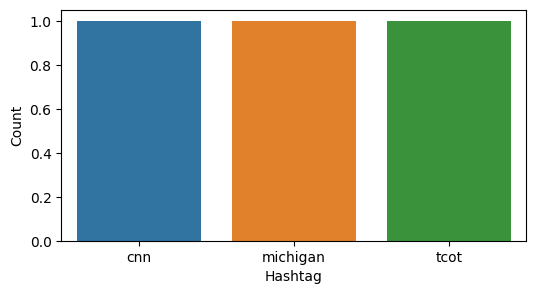

In [102]:
#for rasist and sexist tweets
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

#selecting top 10 frequent hashtags
e = e.nlargest(columns = 'Count',n = 10)
plt.figure(figsize = (6,3))
ax = sns.barplot(data =e,x = "Hashtag",y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [103]:
#countervectorizer 

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000,stop_words = 'english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow 

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 191502 stored elements in Compressed Sparse Row format>

In [104]:
#TF-IDF features


from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = 0.90,min_df = 2, max_features = 1000, stop_words = 'english')

#feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 191502 stored elements in Compressed Sparse Row format>

In [106]:
#building a model bagof words features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


train_bow = bow[:31962,:]
test_bow = bow[316962:,:]

#spliting and train test data
xtrain_bow ,xvalid_bow,ytrain,yvalid = train_test_split(train_bow,train['label'])

lreg = LogisticRegression()
lreg.fit(xtrain_bow,ytrain)

prediction = lreg.predict_proba(xvalid_bow)#predicting validation set
prediction_int = prediction[:,1] >= 3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid,prediction_int)

0.0